# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from gluonnlp.data import BERTSentenceTransform
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:02.042737
Time for [read within]: 0:00:01.959090


In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:31.630622
Time for [tag cross test]: 0:00:17.953293
Time for [tag within traindev]: 0:00:33.695087
Time for [tag within test]: 0:00:16.573657


## Train model - Baseline

### train dev set - 70% 30%

In [28]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'tag']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [10]:
class AdvBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(AdvBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([
                    row['argument1'], row['argument2'],
                    ("1" if str(row['is_same_side']) == "True" else "0",
                     row['tag'])
                ])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples


class AdvBERTDatasetTransform(object):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 labels_adv=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32',
                 label_adv_dtype='float32'):
        self.label_dtype = label_dtype
        self.label_adv_dtype = label_adv_dtype
        self.labels = labels
        self.labels_adv = labels_adv
        if self.labels:
            self._label_map = {}
            for (i, label) in enumerate(labels):
                self._label_map[label] = i
        if self.labels_adv:
            self._label_adv_map = {}
            for (i, label_adv) in enumerate(labels_adv):
                self._label_adv_map[label_adv] = i
        self._bert_xform = BERTSentenceTransform(tokenizer,
                                                 max_seq_length,
                                                 pad=pad,
                                                 pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids = self._bert_xform(line[:-1])

        label, label_adv = line[-1]
        if self.labels:  # for classification task
            label = self._label_map[label]
        if self.labels_adv:
            label_adv = self._label_adv_map[label_adv]
        label = np.array([label], dtype=self.label_dtype)
        label_adv = np.array([label_adv], dtype=self.label_adv_dtype)

        return input_ids, valid_length, segment_ids, (label, label_adv)

**TODO**: my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [11]:
class AdvSigmoidBinaryCrossEntropyLoss(gluon.loss.SigmoidBinaryCrossEntropyLoss):
    def __init__(self, from_sigmoid=False, weight=None, batch_axis=0, **kwargs):
        super(AdvSigmoidBinaryCrossEntropyLoss, self).__init__(from_sigmoid=from_sigmoid, weight=weight, batch_axis=batch_axis, **kwargs)

    def hybrid_forward(self, F, pred, label, sample_weight=None):
        label = _reshape_like(F, label, pred)
        if not self._from_sigmoid:
            # We use the stable formula: max(x, 0) - x * z + log(1 + exp(-abs(x)))
            loss = F.relu(pred) - pred * label + F.Activation(-F.abs(pred), act_type='softrelu')
        else:
            loss = -(F.log(pred+1e-12)*label + F.log(1.-pred+1e-12)*(1.-label))
        loss = _apply_weighting(F, loss, self._weight, sample_weight)
        loss = -loss  # EK
        return F.mean(loss, axis=self._batch_axis, exclude=True)


class AdvSoftmaxCrossEntropyLoss(gluon.loss.SoftmaxCrossEntropyLoss):
    def __init__(self, axis=-1, sparse_label=True, from_logits=False, weight=None,
                 batch_axis=0, **kwargs):
        super(AdvSoftmaxCrossEntropyLoss, self).__init__(axis=axis, sparse_label=sparse_label, from_logits=from_logits, weight=weight, batch_axis=batch_axis, **kwargs)

    def hybrid_forward(self, F, pred, label, sample_weight=None):
        if not self._from_logits:
            pred = F.log_softmax(pred, self._axis)
        if self._sparse_label:
            loss = -F.pick(pred, label, axis=self._axis, keepdims=True)
        else:
            label = _reshape_like(F, label, pred)
            loss = -F.sum(pred*label, axis=self._axis, keepdims=True)
        loss = _apply_weighting(F, loss, self._weight, sample_weight)
        loss = -loss  # EK
        return F.mean(loss, axis=self._batch_axis, exclude=True)

In [24]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTAdversarialClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    num_classes_adv : int, default is 2
        The number of target classes for adversarial classifier.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 num_classes_adv=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTAdversarialClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

            self.adversarial_classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.adversarial_classifier.add(nn.Dropout(rate=dropout))
            self.adversarial_classifier.add(nn.Dense(units=num_classes_adv))

    def forward(self, inputs, token_types, valid_length=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        outputs_adv : NDArray
            Shape (batch_size, num_classes_adv), outputs of adversarial classifier.
        """
        _, pooler_out = self.bert(inputs, token_types, valid_length)
        classifier_out = self.classifier(pooler_out)
        adversarial_classifier_out = self.adversarial_classifier(pooler_out)
        return (classifier_out, adversarial_classifier_out)

In [13]:
# for chunked arguments, we may have to compute it all at once beforehand, should not be that much
# since we call with any `*BERTSentenceTransform` object, 
#    splitting the lines may have to be done before a transformation of a line?
#    -> chunking / sentence splitting, then feeding the result into the transformer, ...
from mxnet.gluon.data import Dataset, SimpleDataset


class MySimpleDataset(SimpleDataset):
    """Simple Dataset wrapper for lists and arrays.

    Parameters
    ----------
    data : dataset-like object
        Any object that implements `len()` and `[]`.
    """
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]
    
    def transform(self, fn, lazy=True):
        """Returns a new dataset with each sample transformed by the
        transformer function `fn`.

        Parameters
        ----------
        fn : callable
            A transformer function that takes a sample as input and
            returns the transformed sample.
        lazy : bool, default True
            If False, transforms all samples at once. Otherwise,
            transforms each sample on demand. Note that if `fn`
            is stochastic, you must set lazy to True or you will
            get the same result on all epochs.

        Returns
        -------
        Dataset
            The transformed dataset.
        """
        trans = _MyLazyTransformDataset(self, fn)
        if lazy:
            return trans
        return SimpleDataset([i for i in trans])


class _MyLazyTransformDataset(Dataset):
    """Lazily transformed dataset."""
    def __init__(self, data, fn):
        self._data = data
        self._fn = fn

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        item = self._data[idx]
        if isinstance(item, tuple):
            return self._fn(*item)
        return self._fn(item)

In [14]:
from gluonnlp.data import BERTSentenceTransform


class LastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(MyBERTSentenceTransform, self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)


# TODO: random trim ? --> bad probably
# TODO: segment-wise, e. g. 0 for normal, 1 for tokens after normal tokens, ...

In [15]:
class LastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self, tokenizer, max_seq_length, labels=None, pad=True, pair=True, label_dtype='float32'):
        super(MyBERTDatasetTransform, self).__init__(tokenizer, max_seq_length, labels=labels, pad=pad, pair=pair, label_dtype=label_dtype)
        self._bert_xform = LastPartBERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)

In [37]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = BERTAdversarialClassifier(bert_base, num_classes=2, num_classes_adv=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.adversarial_classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)
    #adv_loss_function = AdvSoftmaxCrossEntropyLoss()
    adv_loss_function = gluon.loss.SoftmaxCELoss()
    adv_loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    adv_metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    max_len = 128  # + batch_size: 32
    # max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    all_adv_labels = ["gay marriage", "abortion"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    # TODO: own dataset transformer
    transform = AdvBERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             labels_adv=all_adv_labels,
                                             label_dtype='int32',
                                             label_adv_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, bert_tokenizer, transform, (loss_function, adv_loss_function), (metric, adv_metric), (all_labels, all_adv_labels)

In [17]:
def transform_dataset(X, y, transform):
    data_train_raw = AdvBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions):
    y_true, y_pred = list(), list()
    y_adv_true, y_adv_pred = list(), list()
    
    for _, y_true_many, y_pred_many, y_adv_true_many, y_adv_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()
        y_adv_true_many = y_adv_true_many.T[0].asnumpy()
        y_adv_pred_many = np.argmax(y_adv_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        y_adv_true.extend(list(y_adv_true_many))
        y_adv_pred.extend(list(y_adv_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_adv_true = np.array(y_adv_true)
    y_adv_pred = np.array(y_adv_pred)
    
    return y_true, y_pred, y_adv_true, y_adv_pred

In [42]:
def train(model,
          data_train,
          ctx,
          metric,
          adv_metric,
          loss_function,
          adv_loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(lengths=[
            int(item[1])
            for item in tqdm(data_train, desc="compute sample lengths")
        ],
                                                    batch_size=batch_size,
                                                    shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               (label,
                                label_adv)) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)
                        label_adv = label_adv.as_in_context(ctx)

                        # forward computation
                        (out, out_adv) = model(token_ids, segment_ids,
                                               valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()
                        ls_adv = adv_loss_function(out_adv, label_adv).mean()

                    # backward computation
                    if batch_id % 2 == 1:
                        ls.backward()
                    else:
                        ls_adv.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1, ignore_stale_grad=True)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    adv_metric.update([label_adv], [out_adv])
                    stats.append((metric.get()[1], ls.asscalar(),
                                  adv_metric.get()[1], ls_adv.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f}, acc_adv={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                adv_metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [19]:
def predict(model, data_predict, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        cum_loss_adv = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       (label, label_adv)) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)
            label_adv = label_adv.as_in_context(ctx)

            # forward computation
            (out, out_adv) = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()
            ls_adv = adv_loss_function(out_adv, label_adv).mean()

            metric.update([label], [out])
            adv_metric.update([label_adv], [out_adv])
            cum_loss += ls.asscalar()  # .sum() ?
            cum_loss_adv += ls_adv.asscalar()
            all_predictions.append((batch_id, label, out, label_adv, out_adv))
            
    return all_predictions, cum_loss, cum_loss_adv

In [31]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3][0])
    print('label_adv = \n%s'%data_train[sample_id][3][1])
    

def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots, adv_acc_dots, adv_loss_dots = zip(*stats)

    plt.subplot(4, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(4, 1, 2)
    plt.plot(x, loss_dots)
    plt.ylabel('Loss')
    
    plt.subplot(4, 1, 3)
    plt.plot(x, adv_acc_dots)  # Linie: '-', 'o-', '.-'
    plt.ylabel('Adv Accuracy')

    plt.subplot(4, 1, 4)
    plt.plot(x, adv_loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Adv Loss')

    plt.show()

### Evaluate

In [21]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [29]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.026474


In [39]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, (loss_function, adv_loss_function), (metric, adv_metric), (all_labels, all_adv_labels) = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [40]:
print(model)

BERTAdversarialClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): MultiHeadAttentionCell(
            (_base_cell): DotProductAttentionCell(
              (_dropout_layer): Dropout(p = 0.1, axes=())
            )
            (proj_query): Dense(768 -> 768, linear)
            (proj_key): Dense(768 -> 768, linear)
            (proj_value): Dense(768 -> 768, linear)
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): BERTPositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 0.1, axes=())
            (layer_norm): BERTLayerNorm(eps=

In [32]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
('1', 'abortion')
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     

  0%|          | 0/1401 [00:00<?, ?it/s]

Time for [setup training]: 0:03:17.564300


  1%|          | 10/1401 [00:08<19:56,  1.16it/s]

[Epoch 0 Batch 10/1401] loss=0.7088, lr=0.0000050, acc=0.472, acc_adv=0.675 - time 0:00:08.421452


  1%|▏         | 20/1401 [00:16<17:58,  1.28it/s]

[Epoch 0 Batch 20/1401] loss=0.6852, lr=0.0000050, acc=0.519, acc_adv=0.647 - time 0:00:07.946128


  2%|▏         | 30/1401 [00:24<17:59,  1.27it/s]

[Epoch 0 Batch 30/1401] loss=0.7136, lr=0.0000050, acc=0.495, acc_adv=0.654 - time 0:00:08.312066


  3%|▎         | 40/1401 [00:32<18:49,  1.20it/s]

[Epoch 0 Batch 40/1401] loss=0.7066, lr=0.0000050, acc=0.491, acc_adv=0.655 - time 0:00:08.070998


  4%|▎         | 50/1401 [00:40<18:15,  1.23it/s]

[Epoch 0 Batch 50/1401] loss=0.6772, lr=0.0000050, acc=0.501, acc_adv=0.666 - time 0:00:08.061635


  4%|▍         | 60/1401 [00:49<17:13,  1.30it/s]

[Epoch 0 Batch 60/1401] loss=0.6703, lr=0.0000050, acc=0.519, acc_adv=0.685 - time 0:00:08.305338


  5%|▍         | 70/1401 [00:57<17:28,  1.27it/s]

[Epoch 0 Batch 70/1401] loss=0.6867, lr=0.0000050, acc=0.525, acc_adv=0.705 - time 0:00:08.219753


  6%|▌         | 80/1401 [01:06<18:49,  1.17it/s]

[Epoch 0 Batch 80/1401] loss=0.7190, lr=0.0000050, acc=0.523, acc_adv=0.721 - time 0:00:08.665112


  6%|▋         | 90/1401 [01:14<18:42,  1.17it/s]

[Epoch 0 Batch 90/1401] loss=0.7190, lr=0.0000050, acc=0.524, acc_adv=0.742 - time 0:00:08.495211


  7%|▋         | 100/1401 [01:22<17:07,  1.27it/s]

[Epoch 0 Batch 100/1401] loss=0.7023, lr=0.0000050, acc=0.522, acc_adv=0.758 - time 0:00:08.075305


  8%|▊         | 110/1401 [01:30<16:40,  1.29it/s]

[Epoch 0 Batch 110/1401] loss=0.7052, lr=0.0000050, acc=0.521, acc_adv=0.776 - time 0:00:07.858756


  9%|▊         | 120/1401 [01:38<18:24,  1.16it/s]

[Epoch 0 Batch 120/1401] loss=0.6925, lr=0.0000050, acc=0.522, acc_adv=0.789 - time 0:00:08.438726


  9%|▉         | 130/1401 [01:46<17:15,  1.23it/s]

[Epoch 0 Batch 130/1401] loss=0.6822, lr=0.0000050, acc=0.523, acc_adv=0.804 - time 0:00:07.925404


 10%|▉         | 140/1401 [01:53<15:12,  1.38it/s]

[Epoch 0 Batch 140/1401] loss=0.7100, lr=0.0000050, acc=0.522, acc_adv=0.816 - time 0:00:06.912647


 11%|█         | 150/1401 [02:02<16:22,  1.27it/s]

[Epoch 0 Batch 150/1401] loss=0.6882, lr=0.0000050, acc=0.523, acc_adv=0.827 - time 0:00:08.257079


 11%|█▏        | 160/1401 [02:09<15:48,  1.31it/s]

[Epoch 0 Batch 160/1401] loss=0.7072, lr=0.0000050, acc=0.522, acc_adv=0.837 - time 0:00:07.896651


 12%|█▏        | 170/1401 [02:17<15:21,  1.34it/s]

[Epoch 0 Batch 170/1401] loss=0.6912, lr=0.0000050, acc=0.524, acc_adv=0.846 - time 0:00:07.881633


 13%|█▎        | 180/1401 [02:26<17:55,  1.14it/s]

[Epoch 0 Batch 180/1401] loss=0.6860, lr=0.0000050, acc=0.527, acc_adv=0.854 - time 0:00:08.896705


 14%|█▎        | 190/1401 [02:35<16:57,  1.19it/s]

[Epoch 0 Batch 190/1401] loss=0.6808, lr=0.0000050, acc=0.528, acc_adv=0.860 - time 0:00:08.383667


 14%|█▍        | 200/1401 [02:43<15:22,  1.30it/s]

[Epoch 0 Batch 200/1401] loss=0.7008, lr=0.0000050, acc=0.528, acc_adv=0.867 - time 0:00:08.146203


 15%|█▍        | 210/1401 [02:51<15:40,  1.27it/s]

[Epoch 0 Batch 210/1401] loss=0.7001, lr=0.0000050, acc=0.527, acc_adv=0.873 - time 0:00:08.145179


 16%|█▌        | 220/1401 [02:59<16:32,  1.19it/s]

[Epoch 0 Batch 220/1401] loss=0.6850, lr=0.0000050, acc=0.529, acc_adv=0.878 - time 0:00:07.977356


 16%|█▋        | 230/1401 [03:07<16:35,  1.18it/s]

[Epoch 0 Batch 230/1401] loss=0.7023, lr=0.0000050, acc=0.528, acc_adv=0.883 - time 0:00:07.876282


 17%|█▋        | 240/1401 [03:15<15:51,  1.22it/s]

[Epoch 0 Batch 240/1401] loss=0.6848, lr=0.0000050, acc=0.528, acc_adv=0.888 - time 0:00:08.076623


 18%|█▊        | 250/1401 [03:23<14:32,  1.32it/s]

[Epoch 0 Batch 250/1401] loss=0.6818, lr=0.0000050, acc=0.530, acc_adv=0.891 - time 0:00:08.209861


 19%|█▊        | 260/1401 [03:31<15:17,  1.24it/s]

[Epoch 0 Batch 260/1401] loss=0.6916, lr=0.0000050, acc=0.530, acc_adv=0.895 - time 0:00:08.049471


 19%|█▉        | 270/1401 [03:40<16:30,  1.14it/s]

[Epoch 0 Batch 270/1401] loss=0.6880, lr=0.0000050, acc=0.531, acc_adv=0.899 - time 0:00:08.633450


 20%|█▉        | 280/1401 [03:48<14:24,  1.30it/s]

[Epoch 0 Batch 280/1401] loss=0.6702, lr=0.0000050, acc=0.533, acc_adv=0.902 - time 0:00:07.986422


 21%|██        | 290/1401 [03:56<14:31,  1.27it/s]

[Epoch 0 Batch 290/1401] loss=0.6545, lr=0.0000050, acc=0.537, acc_adv=0.905 - time 0:00:08.307470


 21%|██▏       | 300/1401 [04:05<15:49,  1.16it/s]

[Epoch 0 Batch 300/1401] loss=0.6778, lr=0.0000050, acc=0.538, acc_adv=0.908 - time 0:00:08.547732


 22%|██▏       | 310/1401 [04:13<14:54,  1.22it/s]

[Epoch 0 Batch 310/1401] loss=0.6757, lr=0.0000050, acc=0.538, acc_adv=0.910 - time 0:00:08.579035


 23%|██▎       | 320/1401 [04:21<14:07,  1.28it/s]

[Epoch 0 Batch 320/1401] loss=0.6735, lr=0.0000050, acc=0.540, acc_adv=0.913 - time 0:00:08.213460


 24%|██▎       | 330/1401 [04:30<15:32,  1.15it/s]

[Epoch 0 Batch 330/1401] loss=0.6593, lr=0.0000050, acc=0.542, acc_adv=0.915 - time 0:00:08.634081


 24%|██▍       | 340/1401 [04:39<15:39,  1.13it/s]

[Epoch 0 Batch 340/1401] loss=0.6861, lr=0.0000050, acc=0.541, acc_adv=0.917 - time 0:00:08.641706


 25%|██▍       | 350/1401 [04:47<15:21,  1.14it/s]

[Epoch 0 Batch 350/1401] loss=0.6982, lr=0.0000050, acc=0.541, acc_adv=0.920 - time 0:00:08.542147


 26%|██▌       | 360/1401 [04:56<15:17,  1.13it/s]

[Epoch 0 Batch 360/1401] loss=0.6595, lr=0.0000050, acc=0.544, acc_adv=0.922 - time 0:00:08.495775


 26%|██▋       | 370/1401 [05:04<13:56,  1.23it/s]

[Epoch 0 Batch 370/1401] loss=0.6663, lr=0.0000050, acc=0.545, acc_adv=0.924 - time 0:00:08.216595


 27%|██▋       | 380/1401 [05:13<15:12,  1.12it/s]

[Epoch 0 Batch 380/1401] loss=0.6532, lr=0.0000050, acc=0.546, acc_adv=0.925 - time 0:00:08.884722


 28%|██▊       | 390/1401 [05:21<14:06,  1.19it/s]

[Epoch 0 Batch 390/1401] loss=0.6841, lr=0.0000050, acc=0.546, acc_adv=0.927 - time 0:00:08.102727


 29%|██▊       | 400/1401 [05:29<12:21,  1.35it/s]

[Epoch 0 Batch 400/1401] loss=0.6558, lr=0.0000050, acc=0.547, acc_adv=0.929 - time 0:00:08.291999


 29%|██▉       | 410/1401 [05:37<12:06,  1.36it/s]

[Epoch 0 Batch 410/1401] loss=0.6872, lr=0.0000050, acc=0.548, acc_adv=0.930 - time 0:00:08.018012


 30%|██▉       | 420/1401 [05:45<12:18,  1.33it/s]

[Epoch 0 Batch 420/1401] loss=0.6936, lr=0.0000050, acc=0.547, acc_adv=0.932 - time 0:00:07.352963


 31%|███       | 430/1401 [05:53<13:06,  1.23it/s]

[Epoch 0 Batch 430/1401] loss=0.6928, lr=0.0000050, acc=0.546, acc_adv=0.933 - time 0:00:08.324260


 31%|███▏      | 440/1401 [06:01<12:44,  1.26it/s]

[Epoch 0 Batch 440/1401] loss=0.6871, lr=0.0000050, acc=0.546, acc_adv=0.934 - time 0:00:08.085284


 32%|███▏      | 450/1401 [06:09<12:33,  1.26it/s]

[Epoch 0 Batch 450/1401] loss=0.6669, lr=0.0000050, acc=0.547, acc_adv=0.936 - time 0:00:07.903609


 33%|███▎      | 460/1401 [06:17<13:06,  1.20it/s]

[Epoch 0 Batch 460/1401] loss=0.6560, lr=0.0000050, acc=0.548, acc_adv=0.937 - time 0:00:08.264186


 34%|███▎      | 470/1401 [06:26<13:01,  1.19it/s]

[Epoch 0 Batch 470/1401] loss=0.6855, lr=0.0000050, acc=0.549, acc_adv=0.938 - time 0:00:08.485773


 34%|███▍      | 480/1401 [06:33<11:42,  1.31it/s]

[Epoch 0 Batch 480/1401] loss=0.6783, lr=0.0000050, acc=0.549, acc_adv=0.939 - time 0:00:07.781750


 35%|███▍      | 490/1401 [06:42<12:07,  1.25it/s]

[Epoch 0 Batch 490/1401] loss=0.6911, lr=0.0000050, acc=0.549, acc_adv=0.940 - time 0:00:08.568622


 36%|███▌      | 500/1401 [06:50<12:11,  1.23it/s]

[Epoch 0 Batch 500/1401] loss=0.6971, lr=0.0000050, acc=0.549, acc_adv=0.941 - time 0:00:07.761616


 36%|███▋      | 510/1401 [06:58<11:42,  1.27it/s]

[Epoch 0 Batch 510/1401] loss=0.6713, lr=0.0000050, acc=0.549, acc_adv=0.943 - time 0:00:07.840696


 37%|███▋      | 520/1401 [07:06<12:26,  1.18it/s]

[Epoch 0 Batch 520/1401] loss=0.6762, lr=0.0000050, acc=0.548, acc_adv=0.943 - time 0:00:07.956493


 38%|███▊      | 530/1401 [07:14<12:24,  1.17it/s]

[Epoch 0 Batch 530/1401] loss=0.6806, lr=0.0000050, acc=0.549, acc_adv=0.944 - time 0:00:08.179183


 39%|███▊      | 540/1401 [07:22<12:16,  1.17it/s]

[Epoch 0 Batch 540/1401] loss=0.6558, lr=0.0000050, acc=0.550, acc_adv=0.945 - time 0:00:08.280812


 39%|███▉      | 550/1401 [07:31<12:20,  1.15it/s]

[Epoch 0 Batch 550/1401] loss=0.6751, lr=0.0000050, acc=0.550, acc_adv=0.946 - time 0:00:08.973166


 40%|███▉      | 560/1401 [07:39<12:04,  1.16it/s]

[Epoch 0 Batch 560/1401] loss=0.6570, lr=0.0000050, acc=0.551, acc_adv=0.947 - time 0:00:08.400901


 41%|████      | 570/1401 [07:48<12:20,  1.12it/s]

[Epoch 0 Batch 570/1401] loss=0.6691, lr=0.0000050, acc=0.551, acc_adv=0.948 - time 0:00:08.907186


 41%|████▏     | 580/1401 [07:56<09:40,  1.41it/s]

[Epoch 0 Batch 580/1401] loss=0.6671, lr=0.0000050, acc=0.552, acc_adv=0.949 - time 0:00:07.248846


 42%|████▏     | 590/1401 [08:03<10:31,  1.28it/s]

[Epoch 0 Batch 590/1401] loss=0.6845, lr=0.0000050, acc=0.552, acc_adv=0.949 - time 0:00:07.785948


 43%|████▎     | 600/1401 [08:12<11:38,  1.15it/s]

[Epoch 0 Batch 600/1401] loss=0.6741, lr=0.0000050, acc=0.552, acc_adv=0.950 - time 0:00:08.354235


 44%|████▎     | 610/1401 [08:20<09:58,  1.32it/s]

[Epoch 0 Batch 610/1401] loss=0.6855, lr=0.0000050, acc=0.552, acc_adv=0.951 - time 0:00:08.013308


 44%|████▍     | 620/1401 [08:28<10:54,  1.19it/s]

[Epoch 0 Batch 620/1401] loss=0.6608, lr=0.0000050, acc=0.552, acc_adv=0.952 - time 0:00:08.378455


 45%|████▍     | 630/1401 [08:36<09:52,  1.30it/s]

[Epoch 0 Batch 630/1401] loss=0.6528, lr=0.0000050, acc=0.553, acc_adv=0.952 - time 0:00:08.084666


 46%|████▌     | 640/1401 [08:44<10:41,  1.19it/s]

[Epoch 0 Batch 640/1401] loss=0.6630, lr=0.0000050, acc=0.554, acc_adv=0.953 - time 0:00:08.002946


 46%|████▋     | 650/1401 [08:52<10:02,  1.25it/s]

[Epoch 0 Batch 650/1401] loss=0.6754, lr=0.0000050, acc=0.554, acc_adv=0.954 - time 0:00:07.614580


 47%|████▋     | 660/1401 [08:59<09:50,  1.26it/s]

[Epoch 0 Batch 660/1401] loss=0.6655, lr=0.0000050, acc=0.554, acc_adv=0.954 - time 0:00:07.563440


 48%|████▊     | 670/1401 [09:07<09:41,  1.26it/s]

[Epoch 0 Batch 670/1401] loss=0.6735, lr=0.0000050, acc=0.554, acc_adv=0.955 - time 0:00:08.091305


 49%|████▊     | 680/1401 [09:16<10:13,  1.18it/s]

[Epoch 0 Batch 680/1401] loss=0.6457, lr=0.0000050, acc=0.555, acc_adv=0.955 - time 0:00:08.443271


 49%|████▉     | 690/1401 [09:24<09:25,  1.26it/s]

[Epoch 0 Batch 690/1401] loss=0.6870, lr=0.0000050, acc=0.555, acc_adv=0.956 - time 0:00:07.853791


 50%|████▉     | 700/1401 [09:31<08:43,  1.34it/s]

[Epoch 0 Batch 700/1401] loss=0.6838, lr=0.0000050, acc=0.555, acc_adv=0.956 - time 0:00:07.521405


 51%|█████     | 710/1401 [09:40<09:03,  1.27it/s]

[Epoch 0 Batch 710/1401] loss=0.6656, lr=0.0000050, acc=0.555, acc_adv=0.957 - time 0:00:08.235796


 51%|█████▏    | 720/1401 [09:47<08:19,  1.36it/s]

[Epoch 0 Batch 720/1401] loss=0.6734, lr=0.0000050, acc=0.555, acc_adv=0.957 - time 0:00:07.720361


 52%|█████▏    | 730/1401 [09:55<09:01,  1.24it/s]

[Epoch 0 Batch 730/1401] loss=0.6668, lr=0.0000050, acc=0.556, acc_adv=0.958 - time 0:00:07.778630


 53%|█████▎    | 740/1401 [10:03<08:59,  1.22it/s]

[Epoch 0 Batch 740/1401] loss=0.6842, lr=0.0000050, acc=0.556, acc_adv=0.958 - time 0:00:08.071807


 54%|█████▎    | 750/1401 [10:11<08:34,  1.26it/s]

[Epoch 0 Batch 750/1401] loss=0.6769, lr=0.0000050, acc=0.556, acc_adv=0.959 - time 0:00:07.727762


 54%|█████▍    | 760/1401 [10:20<09:42,  1.10it/s]

[Epoch 0 Batch 760/1401] loss=0.6641, lr=0.0000050, acc=0.556, acc_adv=0.959 - time 0:00:08.770859


 55%|█████▍    | 770/1401 [10:28<08:22,  1.25it/s]

[Epoch 0 Batch 770/1401] loss=0.6592, lr=0.0000050, acc=0.557, acc_adv=0.960 - time 0:00:07.910243


 56%|█████▌    | 780/1401 [10:36<08:17,  1.25it/s]

[Epoch 0 Batch 780/1401] loss=0.6528, lr=0.0000050, acc=0.558, acc_adv=0.960 - time 0:00:08.170712


 56%|█████▋    | 790/1401 [10:43<07:26,  1.37it/s]

[Epoch 0 Batch 790/1401] loss=0.6829, lr=0.0000050, acc=0.557, acc_adv=0.960 - time 0:00:07.619949


 57%|█████▋    | 800/1401 [10:52<08:34,  1.17it/s]

[Epoch 0 Batch 800/1401] loss=0.6636, lr=0.0000050, acc=0.558, acc_adv=0.961 - time 0:00:08.529886


 58%|█████▊    | 810/1401 [11:00<08:10,  1.21it/s]

[Epoch 0 Batch 810/1401] loss=0.6632, lr=0.0000050, acc=0.558, acc_adv=0.961 - time 0:00:08.257863


 59%|█████▊    | 820/1401 [11:09<08:35,  1.13it/s]

[Epoch 0 Batch 820/1401] loss=0.6499, lr=0.0000050, acc=0.559, acc_adv=0.961 - time 0:00:08.761111


 59%|█████▉    | 830/1401 [11:16<07:18,  1.30it/s]

[Epoch 0 Batch 830/1401] loss=0.6806, lr=0.0000050, acc=0.559, acc_adv=0.962 - time 0:00:07.565023


 60%|█████▉    | 840/1401 [11:25<07:37,  1.23it/s]

[Epoch 0 Batch 840/1401] loss=0.6553, lr=0.0000050, acc=0.559, acc_adv=0.962 - time 0:00:08.460625


 61%|██████    | 850/1401 [11:33<07:16,  1.26it/s]

[Epoch 0 Batch 850/1401] loss=0.6717, lr=0.0000050, acc=0.559, acc_adv=0.963 - time 0:00:08.264150


 61%|██████▏   | 860/1401 [11:41<06:41,  1.35it/s]

[Epoch 0 Batch 860/1401] loss=0.6878, lr=0.0000050, acc=0.559, acc_adv=0.963 - time 0:00:07.678530


 62%|██████▏   | 870/1401 [11:49<06:59,  1.27it/s]

[Epoch 0 Batch 870/1401] loss=0.6734, lr=0.0000050, acc=0.559, acc_adv=0.963 - time 0:00:07.905712


 63%|██████▎   | 880/1401 [11:57<06:38,  1.31it/s]

[Epoch 0 Batch 880/1401] loss=0.6460, lr=0.0000050, acc=0.560, acc_adv=0.963 - time 0:00:07.951071


 64%|██████▎   | 890/1401 [12:05<07:00,  1.22it/s]

[Epoch 0 Batch 890/1401] loss=0.6652, lr=0.0000050, acc=0.560, acc_adv=0.964 - time 0:00:08.561501


 64%|██████▍   | 900/1401 [12:13<06:47,  1.23it/s]

[Epoch 0 Batch 900/1401] loss=0.6630, lr=0.0000050, acc=0.560, acc_adv=0.964 - time 0:00:08.090749


 65%|██████▍   | 910/1401 [12:22<06:39,  1.23it/s]

[Epoch 0 Batch 910/1401] loss=0.6501, lr=0.0000050, acc=0.561, acc_adv=0.964 - time 0:00:08.340977


 66%|██████▌   | 920/1401 [12:30<06:33,  1.22it/s]

[Epoch 0 Batch 920/1401] loss=0.6624, lr=0.0000050, acc=0.561, acc_adv=0.965 - time 0:00:08.192752


 66%|██████▋   | 930/1401 [12:38<06:20,  1.24it/s]

[Epoch 0 Batch 930/1401] loss=0.6597, lr=0.0000050, acc=0.561, acc_adv=0.965 - time 0:00:08.286205


 67%|██████▋   | 940/1401 [12:46<06:19,  1.21it/s]

[Epoch 0 Batch 940/1401] loss=0.6710, lr=0.0000050, acc=0.561, acc_adv=0.965 - time 0:00:07.973544


 68%|██████▊   | 950/1401 [12:54<05:50,  1.29it/s]

[Epoch 0 Batch 950/1401] loss=0.6557, lr=0.0000050, acc=0.561, acc_adv=0.966 - time 0:00:07.846744


 69%|██████▊   | 960/1401 [13:01<05:26,  1.35it/s]

[Epoch 0 Batch 960/1401] loss=0.6602, lr=0.0000050, acc=0.562, acc_adv=0.966 - time 0:00:07.404494


 69%|██████▉   | 970/1401 [13:09<05:29,  1.31it/s]

[Epoch 0 Batch 970/1401] loss=0.6550, lr=0.0000050, acc=0.562, acc_adv=0.966 - time 0:00:07.990674


 70%|██████▉   | 980/1401 [13:17<05:10,  1.35it/s]

[Epoch 0 Batch 980/1401] loss=0.6571, lr=0.0000050, acc=0.562, acc_adv=0.966 - time 0:00:07.645624


 71%|███████   | 990/1401 [13:25<05:09,  1.33it/s]

[Epoch 0 Batch 990/1401] loss=0.6639, lr=0.0000050, acc=0.563, acc_adv=0.966 - time 0:00:07.734962


 71%|███████▏  | 1000/1401 [13:33<05:25,  1.23it/s]

[Epoch 0 Batch 1000/1401] loss=0.6797, lr=0.0000050, acc=0.563, acc_adv=0.967 - time 0:00:07.719757


 72%|███████▏  | 1010/1401 [13:41<05:36,  1.16it/s]

[Epoch 0 Batch 1010/1401] loss=0.6640, lr=0.0000050, acc=0.563, acc_adv=0.967 - time 0:00:08.205901


 73%|███████▎  | 1020/1401 [13:49<05:00,  1.27it/s]

[Epoch 0 Batch 1020/1401] loss=0.6432, lr=0.0000050, acc=0.564, acc_adv=0.967 - time 0:00:08.591203


 74%|███████▎  | 1030/1401 [13:58<05:28,  1.13it/s]

[Epoch 0 Batch 1030/1401] loss=0.6562, lr=0.0000050, acc=0.563, acc_adv=0.968 - time 0:00:08.604965


 74%|███████▍  | 1040/1401 [14:07<05:20,  1.13it/s]

[Epoch 0 Batch 1040/1401] loss=0.6280, lr=0.0000050, acc=0.564, acc_adv=0.968 - time 0:00:08.705703


 75%|███████▍  | 1050/1401 [14:15<04:26,  1.32it/s]

[Epoch 0 Batch 1050/1401] loss=0.6556, lr=0.0000050, acc=0.564, acc_adv=0.968 - time 0:00:08.049031


 76%|███████▌  | 1060/1401 [14:23<04:50,  1.17it/s]

[Epoch 0 Batch 1060/1401] loss=0.6651, lr=0.0000050, acc=0.564, acc_adv=0.968 - time 0:00:08.218961


 76%|███████▋  | 1070/1401 [14:31<04:21,  1.26it/s]

[Epoch 0 Batch 1070/1401] loss=0.6564, lr=0.0000050, acc=0.564, acc_adv=0.969 - time 0:00:07.663829


 77%|███████▋  | 1080/1401 [14:39<04:50,  1.11it/s]

[Epoch 0 Batch 1080/1401] loss=0.6411, lr=0.0000050, acc=0.565, acc_adv=0.969 - time 0:00:08.204374


 78%|███████▊  | 1090/1401 [14:47<04:02,  1.28it/s]

[Epoch 0 Batch 1090/1401] loss=0.6335, lr=0.0000050, acc=0.566, acc_adv=0.969 - time 0:00:08.217617


 79%|███████▊  | 1100/1401 [14:55<04:06,  1.22it/s]

[Epoch 0 Batch 1100/1401] loss=0.6263, lr=0.0000050, acc=0.566, acc_adv=0.969 - time 0:00:08.419333


 79%|███████▉  | 1110/1401 [15:03<03:35,  1.35it/s]

[Epoch 0 Batch 1110/1401] loss=0.6625, lr=0.0000050, acc=0.567, acc_adv=0.969 - time 0:00:07.375978


 80%|███████▉  | 1120/1401 [15:11<04:04,  1.15it/s]

[Epoch 0 Batch 1120/1401] loss=0.6350, lr=0.0000050, acc=0.567, acc_adv=0.970 - time 0:00:08.442038


 81%|████████  | 1130/1401 [15:20<03:44,  1.21it/s]

[Epoch 0 Batch 1130/1401] loss=0.6414, lr=0.0000050, acc=0.568, acc_adv=0.970 - time 0:00:08.364810


 81%|████████▏ | 1140/1401 [15:28<03:21,  1.29it/s]

[Epoch 0 Batch 1140/1401] loss=0.6542, lr=0.0000050, acc=0.568, acc_adv=0.970 - time 0:00:07.959781


 82%|████████▏ | 1150/1401 [15:36<03:26,  1.21it/s]

[Epoch 0 Batch 1150/1401] loss=0.6269, lr=0.0000050, acc=0.569, acc_adv=0.970 - time 0:00:08.412931


 83%|████████▎ | 1160/1401 [15:44<03:14,  1.24it/s]

[Epoch 0 Batch 1160/1401] loss=0.6240, lr=0.0000050, acc=0.569, acc_adv=0.970 - time 0:00:08.137760


 84%|████████▎ | 1170/1401 [15:52<03:07,  1.23it/s]

[Epoch 0 Batch 1170/1401] loss=0.6679, lr=0.0000050, acc=0.570, acc_adv=0.971 - time 0:00:07.923003


 84%|████████▍ | 1180/1401 [16:00<02:38,  1.40it/s]

[Epoch 0 Batch 1180/1401] loss=0.6447, lr=0.0000050, acc=0.570, acc_adv=0.971 - time 0:00:07.684225


 85%|████████▍ | 1190/1401 [16:08<02:40,  1.32it/s]

[Epoch 0 Batch 1190/1401] loss=0.6546, lr=0.0000050, acc=0.570, acc_adv=0.971 - time 0:00:07.891693


 86%|████████▌ | 1200/1401 [16:16<02:47,  1.20it/s]

[Epoch 0 Batch 1200/1401] loss=0.6447, lr=0.0000050, acc=0.571, acc_adv=0.971 - time 0:00:08.276304


 86%|████████▋ | 1210/1401 [16:24<02:39,  1.19it/s]

[Epoch 0 Batch 1210/1401] loss=0.6461, lr=0.0000050, acc=0.571, acc_adv=0.971 - time 0:00:08.312675


 87%|████████▋ | 1220/1401 [16:33<02:37,  1.15it/s]

[Epoch 0 Batch 1220/1401] loss=0.6066, lr=0.0000050, acc=0.572, acc_adv=0.971 - time 0:00:08.405964


 88%|████████▊ | 1230/1401 [16:41<02:24,  1.19it/s]

[Epoch 0 Batch 1230/1401] loss=0.6149, lr=0.0000050, acc=0.572, acc_adv=0.972 - time 0:00:08.282503


 89%|████████▊ | 1240/1401 [16:49<02:09,  1.24it/s]

[Epoch 0 Batch 1240/1401] loss=0.6268, lr=0.0000050, acc=0.572, acc_adv=0.972 - time 0:00:08.097860


 89%|████████▉ | 1250/1401 [16:58<02:04,  1.21it/s]

[Epoch 0 Batch 1250/1401] loss=0.6423, lr=0.0000050, acc=0.573, acc_adv=0.972 - time 0:00:08.659085


 90%|████████▉ | 1260/1401 [17:06<01:57,  1.20it/s]

[Epoch 0 Batch 1260/1401] loss=0.5781, lr=0.0000050, acc=0.574, acc_adv=0.972 - time 0:00:08.229800


 91%|█████████ | 1270/1401 [17:14<01:48,  1.21it/s]

[Epoch 0 Batch 1270/1401] loss=0.6216, lr=0.0000050, acc=0.574, acc_adv=0.972 - time 0:00:08.036589


 91%|█████████▏| 1280/1401 [17:22<01:31,  1.32it/s]

[Epoch 0 Batch 1280/1401] loss=0.6459, lr=0.0000050, acc=0.574, acc_adv=0.972 - time 0:00:07.932153


 92%|█████████▏| 1290/1401 [17:30<01:23,  1.33it/s]

[Epoch 0 Batch 1290/1401] loss=0.6218, lr=0.0000050, acc=0.575, acc_adv=0.972 - time 0:00:07.765650


 93%|█████████▎| 1300/1401 [17:37<01:19,  1.27it/s]

[Epoch 0 Batch 1300/1401] loss=0.6332, lr=0.0000050, acc=0.575, acc_adv=0.973 - time 0:00:07.689333


 94%|█████████▎| 1310/1401 [17:46<01:15,  1.20it/s]

[Epoch 0 Batch 1310/1401] loss=0.6245, lr=0.0000050, acc=0.575, acc_adv=0.973 - time 0:00:08.181424


 94%|█████████▍| 1320/1401 [17:54<01:10,  1.15it/s]

[Epoch 0 Batch 1320/1401] loss=0.5784, lr=0.0000050, acc=0.576, acc_adv=0.973 - time 0:00:08.624589


 95%|█████████▍| 1330/1401 [18:02<01:01,  1.16it/s]

[Epoch 0 Batch 1330/1401] loss=0.6138, lr=0.0000050, acc=0.577, acc_adv=0.973 - time 0:00:08.240998


 96%|█████████▌| 1340/1401 [18:10<00:47,  1.29it/s]

[Epoch 0 Batch 1340/1401] loss=0.6222, lr=0.0000050, acc=0.578, acc_adv=0.973 - time 0:00:07.844579


 96%|█████████▋| 1350/1401 [18:19<00:42,  1.20it/s]

[Epoch 0 Batch 1350/1401] loss=0.5896, lr=0.0000050, acc=0.578, acc_adv=0.973 - time 0:00:08.236978


 97%|█████████▋| 1360/1401 [18:27<00:35,  1.16it/s]

[Epoch 0 Batch 1360/1401] loss=0.6269, lr=0.0000050, acc=0.578, acc_adv=0.974 - time 0:00:08.772155


 98%|█████████▊| 1370/1401 [18:35<00:26,  1.18it/s]

[Epoch 0 Batch 1370/1401] loss=0.6308, lr=0.0000050, acc=0.578, acc_adv=0.974 - time 0:00:08.135095


 99%|█████████▊| 1380/1401 [18:44<00:16,  1.28it/s]

[Epoch 0 Batch 1380/1401] loss=0.5878, lr=0.0000050, acc=0.579, acc_adv=0.974 - time 0:00:08.140705


 99%|█████████▉| 1390/1401 [18:52<00:09,  1.13it/s]

[Epoch 0 Batch 1390/1401] loss=0.6152, lr=0.0000050, acc=0.580, acc_adv=0.974 - time 0:00:08.385790


100%|█████████▉| 1400/1401 [18:59<00:00,  1.32it/s]

[Epoch 0 Batch 1400/1401] loss=0.6349, lr=0.0000050, acc=0.580, acc_adv=0.974 - time 0:00:07.310794


100%|██████████| 1401/1401 [19:00<00:00,  1.22it/s]


Time for [epoch 0]: 0:19:00.752625
Time for [training]: 0:19:01.269586


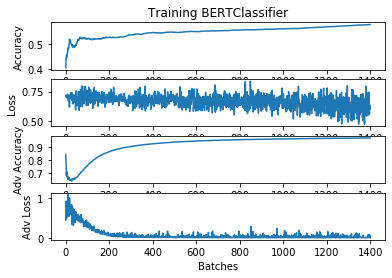

Time for [4 - train model]: 0:22:19.634800


In [43]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32, lr=5e-6, num_epochs=1)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [34]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
('0', 'abortion')
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3 

In [46]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss, cum_loss_adv = predict(model, data_dev, ctx, metric, adv_metric, loss_function, adv_loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)
    report_training_results(y_adv_true, y_adv_pred, name="BERTAdvClassifier", heatmap=False)



  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 1/600 [00:00<03:01,  3.29it/s]

  0%|          | 2/600 [00:00<03:13,  3.09it/s]

  0%|          | 3/600 [00:00<03:12,  3.10it/s]

  1%|          | 4/600 [00:01<03:08,  3.16it/s]

  1%|          | 5/600 [00:01<03:08,  3.16it/s]

  1%|          | 6/600 [00:01<03:02,  3.25it/s]

  1%|          | 7/600 [00:02<03:03,  3.24it/s]

  1%|▏         | 8/600 [00:02<03:01,  3.26it/s]

  2%|▏         | 9/600 [00:02<03:04,  3.21it/s]

  2%|▏         | 10/600 [00:03<02:55,  3.36it/s]

  2%|▏         | 11/600 [00:03<02:50,  3.45it/s]

  2%|▏         | 12/600 [00:03<03:07,  3.13it/s]

  2%|▏         | 13/600 [00:04<03:06,  3.16it/s]

  2%|▏         | 14/600 [00:04<03:14,  3.01it/s]

  2%|▎         | 15/600 [00:04<03:13,  3.03it/s]

  3%|▎         | 16/600 [00:05<03:09,  3.07it/s]

  3%|▎         | 17/600 [00:05<03:11,  3.05it/s]

  3%|▎         | 18/600 [00:05<03:05,  3.13it/s]

  3%|▎         | 19/600 [00:06<03:02,  3.18it/s]

  3%|▎         |

 24%|██▍       | 145/600 [00:44<02:11,  3.47it/s]

 24%|██▍       | 146/600 [00:45<02:13,  3.40it/s]

 24%|██▍       | 147/600 [00:45<02:11,  3.44it/s]

 25%|██▍       | 148/600 [00:45<02:15,  3.33it/s]

 25%|██▍       | 149/600 [00:46<02:18,  3.25it/s]

 25%|██▌       | 150/600 [00:46<02:23,  3.14it/s]

 25%|██▌       | 151/600 [00:46<02:21,  3.16it/s]

 25%|██▌       | 152/600 [00:46<02:18,  3.25it/s]

 26%|██▌       | 153/600 [00:47<02:25,  3.07it/s]

 26%|██▌       | 154/600 [00:47<02:23,  3.11it/s]

 26%|██▌       | 155/600 [00:47<02:18,  3.21it/s]

 26%|██▌       | 156/600 [00:48<02:19,  3.19it/s]

 26%|██▌       | 157/600 [00:48<02:24,  3.06it/s]

 26%|██▋       | 158/600 [00:48<02:21,  3.12it/s]

 26%|██▋       | 159/600 [00:49<02:15,  3.24it/s]

 27%|██▋       | 160/600 [00:49<02:20,  3.12it/s]

 27%|██▋       | 161/600 [00:49<02:15,  3.25it/s]

 27%|██▋       | 162/600 [00:50<02:10,  3.35it/s]

 27%|██▋       | 163/600 [00:50<02:06,  3.46it/s]

 27%|██▋       | 164/600 [00:50

 48%|████▊     | 288/600 [01:29<01:46,  2.92it/s]

 48%|████▊     | 289/600 [01:29<01:48,  2.88it/s]

 48%|████▊     | 290/600 [01:29<01:42,  3.03it/s]

 48%|████▊     | 291/600 [01:30<01:40,  3.08it/s]

 49%|████▊     | 292/600 [01:30<01:38,  3.13it/s]

 49%|████▉     | 293/600 [01:30<01:41,  3.03it/s]

 49%|████▉     | 294/600 [01:31<01:45,  2.90it/s]

 49%|████▉     | 295/600 [01:31<01:41,  3.00it/s]

 49%|████▉     | 296/600 [01:31<01:36,  3.15it/s]

 50%|████▉     | 297/600 [01:32<01:36,  3.14it/s]

 50%|████▉     | 298/600 [01:32<01:34,  3.21it/s]

 50%|████▉     | 299/600 [01:32<01:28,  3.42it/s]

 50%|█████     | 300/600 [01:32<01:28,  3.41it/s]

 50%|█████     | 301/600 [01:33<01:31,  3.28it/s]

 50%|█████     | 302/600 [01:33<01:32,  3.22it/s]

 50%|█████     | 303/600 [01:33<01:27,  3.41it/s]

 51%|█████     | 304/600 [01:34<01:27,  3.37it/s]

 51%|█████     | 305/600 [01:34<01:28,  3.32it/s]

 51%|█████     | 306/600 [01:34<01:32,  3.19it/s]

 51%|█████     | 307/600 [01:35

 72%|███████▏  | 431/600 [02:12<00:53,  3.13it/s]

 72%|███████▏  | 432/600 [02:13<00:56,  2.99it/s]

 72%|███████▏  | 433/600 [02:13<00:52,  3.16it/s]

 72%|███████▏  | 434/600 [02:13<00:56,  2.96it/s]

 72%|███████▎  | 435/600 [02:13<00:51,  3.18it/s]

 73%|███████▎  | 436/600 [02:14<00:50,  3.26it/s]

 73%|███████▎  | 437/600 [02:14<00:51,  3.19it/s]

 73%|███████▎  | 438/600 [02:14<00:52,  3.06it/s]

 73%|███████▎  | 439/600 [02:15<00:48,  3.32it/s]

 73%|███████▎  | 440/600 [02:15<00:46,  3.46it/s]

 74%|███████▎  | 441/600 [02:15<00:48,  3.31it/s]

 74%|███████▎  | 442/600 [02:16<00:46,  3.43it/s]

 74%|███████▍  | 443/600 [02:16<00:45,  3.43it/s]

 74%|███████▍  | 444/600 [02:16<00:44,  3.50it/s]

 74%|███████▍  | 445/600 [02:16<00:44,  3.49it/s]

 74%|███████▍  | 446/600 [02:17<00:43,  3.56it/s]

 74%|███████▍  | 447/600 [02:17<00:42,  3.58it/s]

 75%|███████▍  | 448/600 [02:17<00:44,  3.44it/s]

 75%|███████▍  | 449/600 [02:18<00:43,  3.46it/s]

 75%|███████▌  | 450/600 [02:18

 96%|█████████▌| 574/600 [02:57<00:07,  3.47it/s]

 96%|█████████▌| 575/600 [02:57<00:07,  3.32it/s]

 96%|█████████▌| 576/600 [02:58<00:07,  3.29it/s]

 96%|█████████▌| 577/600 [02:58<00:06,  3.48it/s]

 96%|█████████▋| 578/600 [02:58<00:06,  3.38it/s]

 96%|█████████▋| 579/600 [02:58<00:06,  3.31it/s]

 97%|█████████▋| 580/600 [02:59<00:05,  3.39it/s]

 97%|█████████▋| 581/600 [02:59<00:05,  3.47it/s]

 97%|█████████▋| 582/600 [02:59<00:05,  3.36it/s]

 97%|█████████▋| 583/600 [03:00<00:05,  3.27it/s]

 97%|█████████▋| 584/600 [03:00<00:04,  3.24it/s]

 98%|█████████▊| 585/600 [03:00<00:04,  3.15it/s]

 98%|█████████▊| 586/600 [03:01<00:04,  3.10it/s]

 98%|█████████▊| 587/600 [03:01<00:04,  2.95it/s]

 98%|█████████▊| 588/600 [03:01<00:04,  2.99it/s]

 98%|█████████▊| 589/600 [03:02<00:03,  3.02it/s]

 98%|█████████▊| 590/600 [03:02<00:03,  2.99it/s]

 98%|█████████▊| 591/600 [03:02<00:02,  3.08it/s]

 99%|█████████▊| 592/600 [03:03<00:02,  3.03it/s]

 99%|█████████▉| 593/600 [03:03

Time for [prediction]: 0:03:05.226104
Accuracy: 0.6514527150383391
Confusion Matrix:
[[8113  720]
 [5962 4376]]

Accuracy:  0.65 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.58      0.92      0.71      8833
           1       0.86      0.42      0.57     10338

    accuracy                           0.65     19171
   macro avg       0.72      0.67      0.64     19171
weighted avg       0.73      0.65      0.63     19171

Confusion Matrix:
[[ 6749    92]
 [   29 12301]]

Accuracy:  0.99 

Report for [BERTAdvClassifier]:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6841
           1       0.99      1.00      1.00     12330

    accuracy                           0.99     19171
   macro avg       0.99      0.99      0.99     19171
weighted avg       0.99      0.99      0.99     19171

Time for [6 - evaluate]: 0:03:05.860144


### Train and evaluate each epoch

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss, cum_loss_adv = predict(model, data_dev, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss, cum_loss_adv = predict(model, data_dev, ctx, metric, adv_metric, loss_function, adv_loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred, y_adv_true, y_adv_pred = predict_out_to_ys(all_predictions)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")